In [1]:
!hostname

n82.clstr


In [2]:
import pandas as pd 
import requests
import io
import numpy as np
import matplotlib.pyplot as plt
import glob
import xarray as xr
import geopandas as gpd
import matplotlib.colors as mcolors
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [3]:
winter_months = [11, 12, 1, 2, 3]

Alaska Shapefiles 
-

In [4]:
shapefile_path = "/center1/DYNDOWN/phutton5/ROS/boundaries/Alaska_Borough_and_Census_Area_Boundaries.shp"
borough_boundaries = gpd.read_file(shapefile_path)
borough_boundaries = borough_boundaries.set_crs(epsg=3338)
borough_boundaries = borough_boundaries.to_crs(epsg=4326)
FNSB_boundary = borough_boundaries[borough_boundaries['CommunityN'] == 'Fairbanks North Star Borough']
FNSB_geom = FNSB_boundary.geometry.iloc[0] 
FNSB_coords = []
FNSB_coords.extend(list(FNSB_geom.exterior.coords))
FNSB_coords = np.array(FNSB_coords)  
FNSB_coords = pd.DataFrame({
    "lon": FNSB_coords[:, 0],
    "lat": FNSB_coords[:, 1]})

Fairbanks_lat=(64.84)
Fairbanks_lon=(-147.72)

ASOS 
-

In [5]:
website='https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?network=AK_ASOS&station=PANC&data=tmpc&data=p01m&data=wxcodes&data=snowdepth&year1=1949&month1=10&day1=1&year2=2023&month2=1&day2=1&tz=America%2FAnchorage&format=onlycomma&latlon=yes&elev=no&missing=M&trace=0.0001&direct=no&report_type=3&report_type=4'
#https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?network=AK_ASOS&station=PAFA&data=tmpc&data=p01m&data=wxcodes&data=snowdepth&year1=1950&month1=1&day1=1&year2=2023&month2=12&day2=9&tz=America%2FAnchorage&format=onlycomma&latlon=yes&elev=no&missing=M&trace=T&direct=no&report_type=3&report_type=4'
response = requests.get(website)
if response.status_code == 200:
    data = io.StringIO(response.text)
    df = pd.read_csv(data, comment="#")  
    print(df.head())
else:
    print("Error:", response.status_code)

  station             valid       lon      lat    tmpc p01m wxcodes snowdepth
0    PANC  1953-11-01 00:00 -150.0261  61.1697  -12.22    M       M         M
1    PANC  1953-11-01 01:00 -150.0261  61.1697  -11.67    M       M         M
2    PANC  1953-11-01 02:00 -150.0261  61.1697  -11.11    M      FG         M
3    PANC  1953-11-01 03:00 -150.0261  61.1697   -8.89    M      FG         M
4    PANC  1953-11-01 04:00 -150.0261  61.1697   -9.44    M       M         M


/center1/DYNDOWN/phutton5/VSCODE_dump/ipykernel_1163425/382549803.py:6: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data, comment="#")


In [6]:
df['valid'] = pd.to_datetime(df['valid'])
df['month'] = df['valid'].dt.month
df['date'] = df['valid'].dt.date
df['time'] = df['valid'].dt.time
#df['tmpc']
#df = df.drop(columns=['column_name'])
winter_df = df[df['month'].isin([11, 12, 1, 2, 3])] #filter to only keep the ROS months 

winter_df['date'] = pd.to_datetime(winter_df['date'])
year = winter_df['date'].dt.year
month = winter_df['date'].dt.month
season_start = year.where(~month.isin([1, 2, 3]), year - 1)
season_end = season_start + 1
winter_df['season'] = season_start.astype(str) + '-' + season_end.astype(str)

#filter to only when RA is present 
mask = winter_df['wxcodes'].str.contains('RA', na=False)
rain_and_mixed_df = winter_df[mask]
rain_and_mixed_df['p01m'] = rain_and_mixed_df['p01m'].replace('M', np.nan) 
rain_and_mixed_df['p01m'] = rain_and_mixed_df['p01m'].replace('T', 0.001) 
rain_and_mixed_df['p01m'] = pd.to_numeric(rain_and_mixed_df['p01m'], errors='coerce')

/center1/DYNDOWN/phutton5/VSCODE_dump/ipykernel_1163425/1912088275.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winter_df['date'] = pd.to_datetime(winter_df['date'])
/center1/DYNDOWN/phutton5/VSCODE_dump/ipykernel_1163425/1912088275.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winter_df['season'] = season_start.astype(str) + '-' + season_end.astype(str)
/center1/DYNDOWN/phutton5/VSCODE_dump/ipykernel_1163425/1912088275.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

In [9]:
monthly_order = [11, 12, 1, 2, 3]

seasonal_sum_rain_and_mixed_df = (rain_and_mixed_df.groupby('season')['p01m'].sum())
monthly_sum_by_season_ASOS = (rain_and_mixed_df.groupby(['month'])['p01m'].sum()) 
monthly_sum_by_season_ASOS=monthly_sum_by_season_ASOS.loc[monthly_order]

monthly_mean_by_season_ASOS = rain_and_mixed_df.groupby(['season'])['p01m'].mean()

start_years = seasonal_sum_rain_and_mixed_df.index.str.slice(0, 4).astype(int)
all_seasons = [f"{y}-{y+1}" for y in range(start_years.min(), start_years.max() + 1)]

seasonal_sum_rain_and_mixed_df = seasonal_sum_rain_and_mixed_df.reindex(all_seasons)
seasonal_sum_rain_and_mixed_df=seasonal_sum_rain_and_mixed_df.fillna(0)
seasons_seasonal_sum_rain_and_mixed_df = seasonal_sum_rain_and_mixed_df.index.tolist()

#Rain only, no other precip, not realistic max of 2mm 
'''
mask = winter_df['wxcodes'].str.fullmatch(r'[-+]?(SH)?RA') #matches 'RA' or '-RA' and SH RA
rain_only_df = winter_df[mask]
rain_only_df['p01m'] = rain_only_df['p01m'].replace(['M', 'T'], np.nan)
rain_only_df['p01m'] = pd.to_numeric(rain_only_df['p01m'], errors='coerce') # Convert to numeric (float)

seasonal_sum_rain_only_df = (rain_only_df.loc[rain_only_df['p01m'] >= 0.254].groupby('season')['p01m'].sum())
#seasonal_sum_rain_only_df=rain_only_df.groupby('season')['p01m'].sum()
seasonal_sum_rain_only_df = seasonal_sum_rain_only_df.reindex(all_seasons)
seasonal_sum_rain_only_df=seasonal_sum_rain_only_df.fillna(0)
seasons_seasonal_sum_rain_df = seasonal_sum_rain_only_df.index.tolist()
'''

"\nmask = winter_df['wxcodes'].str.fullmatch(r'[-+]?(SH)?RA') #matches 'RA' or '-RA' and SH RA\nrain_only_df = winter_df[mask]\nrain_only_df['p01m'] = rain_only_df['p01m'].replace(['M', 'T'], np.nan)\nrain_only_df['p01m'] = pd.to_numeric(rain_only_df['p01m'], errors='coerce') # Convert to numeric (float)\n\nseasonal_sum_rain_only_df = (rain_only_df.loc[rain_only_df['p01m'] >= 0.254].groupby('season')['p01m'].sum())\n#seasonal_sum_rain_only_df=rain_only_df.groupby('season')['p01m'].sum()\nseasonal_sum_rain_only_df = seasonal_sum_rain_only_df.reindex(all_seasons)\nseasonal_sum_rain_only_df=seasonal_sum_rain_only_df.fillna(0)\nseasons_seasonal_sum_rain_df = seasonal_sum_rain_only_df.index.tolist()\n"

Plotting
-

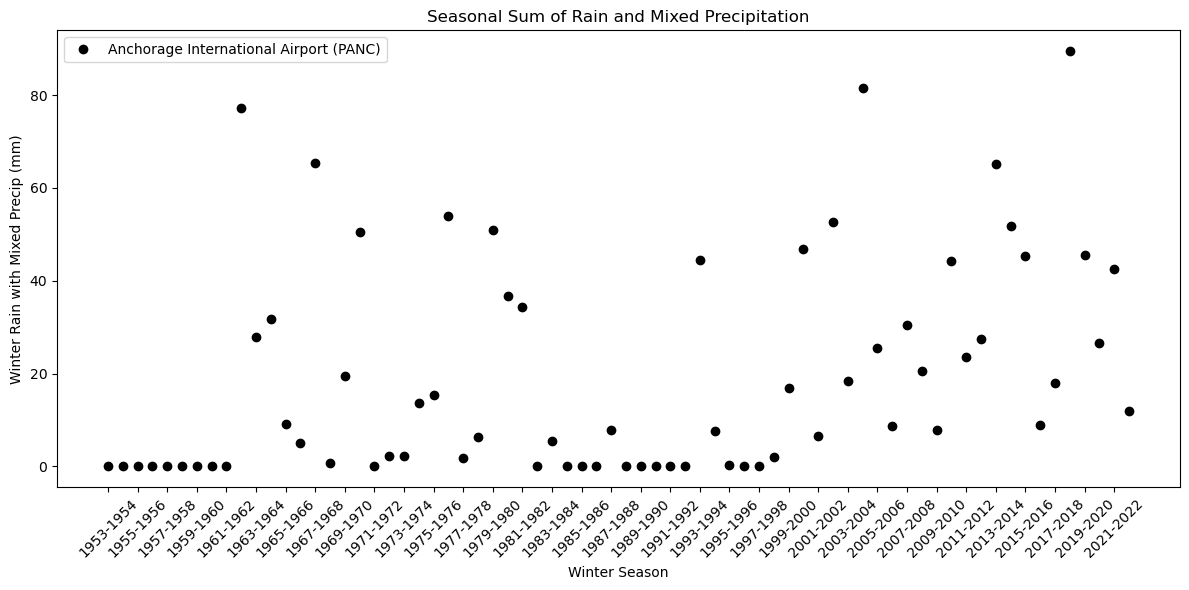

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(seasons_seasonal_sum_rain_and_mixed_df,seasonal_sum_rain_and_mixed_df, marker='o', linestyle='', color='black',label='Anchorage International Airport (PANC)')
plt.gca().patch.set_alpha(0.0)
plt.title('Seasonal Sum of Rain and Mixed Precipitation')
plt.xlabel('Winter Season')
plt.ylabel('Winter Rain with Mixed Precip (mm)')
plt.xticks(ticks=range(0, len(seasons_seasonal_sum_rain_and_mixed_df), 2), labels=seasons_seasonal_sum_rain_and_mixed_df[::2], rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

To Compare PAFA, DYN and RAW
-


In [13]:
panc_lat=61.1697
panc_lon=-150.0261

#selected values later are 61.183758 -149.99158

In [14]:
def getXY(lat, lon, dataarray):
    abslat = np.abs(dataarray.XLAT-lat)
    abslon = np.abs(dataarray.XLONG-lon)
    d = abslon**2 + abslat**2
    flat_index = np.argmin(d.values)
    yloc, xloc = np.unravel_index(flat_index, d.shape)
    return xloc, yloc

def getXY_latlon(lat, lon, dataarray):
    abslat = np.abs(dataarray.latitude - lat)
    abslon = np.abs(dataarray.longitude - lon)
    d = abslon**2 + abslat**2
    flat_index = np.argmin(d.values)
    yloc, xloc = np.unravel_index(flat_index, d.shape)
    return xloc, yloc

In [15]:
regridded_era5_path='/center1/DYNDOWN/phutton5/ROS/All_of_AK/All_of_AK_netcdf_files/ERA5_31kmto4km_nearest_regridded.nc'
regridded_era5=xr.open_dataset(regridded_era5_path)

#ERA5  4km
era5_4km='/center1/DYNDOWN/phutton5/ROS/All_of_AK/All_of_AK_netcdf_files/ROS_Monthly_*.nc'
era5_4km = xr.open_mfdataset(era5_4km,combine="by_coords", parallel=True)


In [16]:
x_idx, y_idx = getXY(panc_lat, panc_lon, regridded_era5)
nearest_lat = regridded_era5.XLAT[y_idx, x_idx]
nearest_lon = regridded_era5.XLONG[y_idx, x_idx]


In [17]:
cell = era5_4km.isel(
    south_north=y_idx,
    west_east=x_idx
)

In [41]:
era5_4km_rain_sum_at_site = era5_4km['rain_ros_sum'].isel(south_north=x_idx,west_east=y_idx)
seasonal_rain_sum_at_site_era5_4km=era5_4km_rain_sum_at_site.sum(dim='month')
monthly_rain_sum_at_site_era5_4km=era5_4km_rain_sum_at_site.sum(dim='season')
#monthly_rain_MEAN_at_site_era5_4km=era5_4km['rain_ros_sum'].isel(south_north=y_idx,west_east=x_idx).groupby('month','season').mean()


era5_regridded_31km_rain_sum_at_site = regridded_era5['rain_ros_sum'].isel(south_north=x_idx,west_east=y_idx)
seasonal_rain_sum_at_site_era5_regridded_31km=era5_regridded_31km_rain_sum_at_site.sum(dim='month')
monthly_rain_sum_at_site_era5_regridded_31km=era5_regridded_31km_rain_sum_at_site.sum(dim='season')

#monthly_rain_MEAN_at_site_era5_regridded_31km=regridded_era5['rain_ros_sum'].isel(south_north=y_idx,west_east=x_idx).groupby('month').mean()

seasons=era5_4km['season']

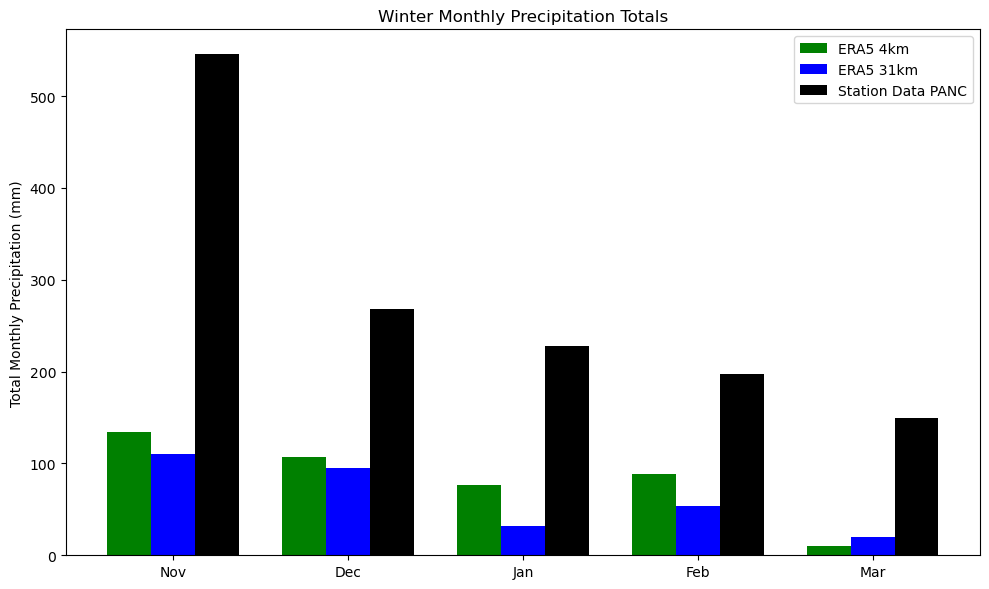

In [ ]:
winter_months = [11, 12, 1, 2, 3]
month_labels = ['Nov','Dec','Jan','Feb','Mar']

sum_4km = []
sum_31km = []
sum_station = []

for month in winter_months:
    sum_4km.append(
        np.sum(monthly_rain_sum_at_site_era5_4km.sel(month=month).values)
    )
    sum_31km.append(
        np.sum(monthly_rain_sum_at_site_era5_regridded_31km.sel(month=month).values)
    )
    sum_station.append(
        monthly_sum_by_season_ASOS[month])

x = np.arange(len(winter_months))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(x - width, sum_4km, width, color='green', label='ERA5 4km')
ax.bar(x,         sum_31km, width, color='blue',  label='ERA5 31km')
ax.bar(x + width, sum_station, width, color='black', label='Station Data PANC')

ax.set_xticks(x)
ax.set_xticklabels(month_labels)
ax.set_ylabel('Total Monthly Precipitation (mm)')
ax.set_title('Winter Monthly Precipitation Totals')
ax.legend()

plt.tight_layout()
plt.show()


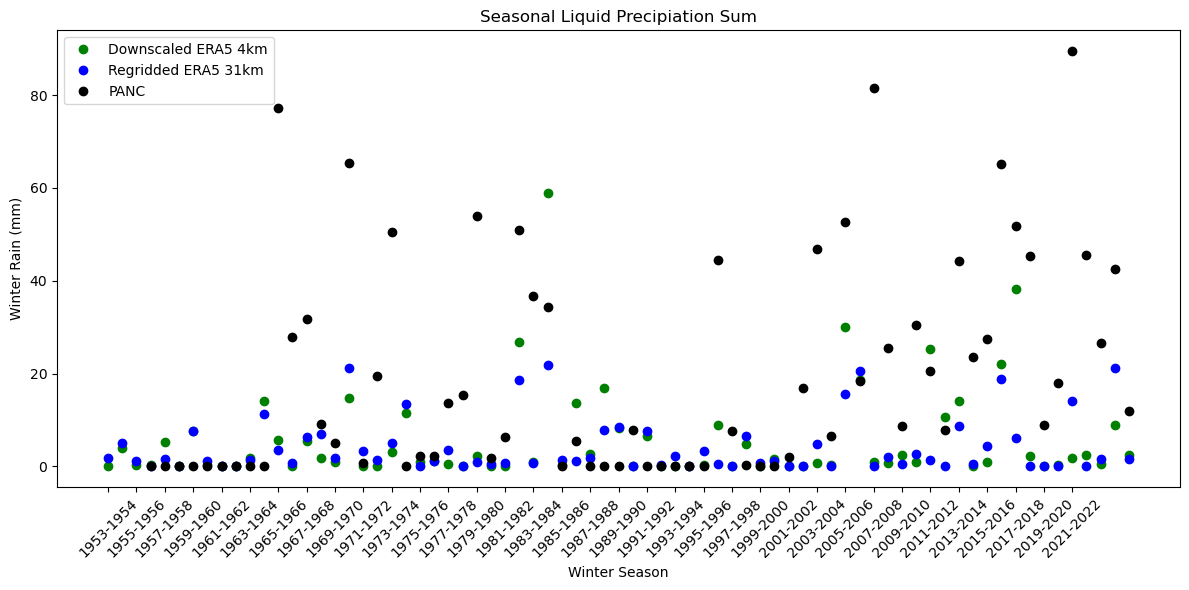

In [20]:
plt.figure(figsize=(12, 6))
#seasonal_rain_sum_at_site_era5_4km
#seasonal_rain_sum_at_site_era5_regridded_31km
#plt.plot(rick_season_full_df['season'],rick_season_full_df['season_sum_rain_mm'], marker='*',markersize=10, linestyle='', color='purple',label='Local Dataset',zorder=10)
plt.plot(seasons,seasonal_rain_sum_at_site_era5_4km, marker='o',label='Downscaled ERA5 4km', linestyle='', color='green')
plt.plot(seasons,seasonal_rain_sum_at_site_era5_regridded_31km, marker='o', label='Regridded ERA5 31km', linestyle='', color='blue')
plt.plot(seasons_seasonal_sum_rain_and_mixed_df,seasonal_sum_rain_and_mixed_df, label='PANC',marker='o', linestyle='', color='black')
plt.gca().patch.set_alpha(0.0)
plt.title('Seasonal Liquid Precipiation Sum')
plt.xlabel('Winter Season')
plt.ylabel('Winter Rain (mm)')
plt.xticks(ticks=range(0, len(seasons_seasonal_sum_rain_and_mixed_df), 2),labels=seasons_seasonal_sum_rain_and_mixed_df[::2],rotation=45) 
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
monthly_rain_sum_at_site_era5_4km
monthly_rain_sum_at_site_era5_regridded_31km
monthly_sum_by_season_ASOS

month
11    545.4851
12    268.6170
1     228.2527
2     197.8849
3     149.3271
Name: p01m, dtype: float64

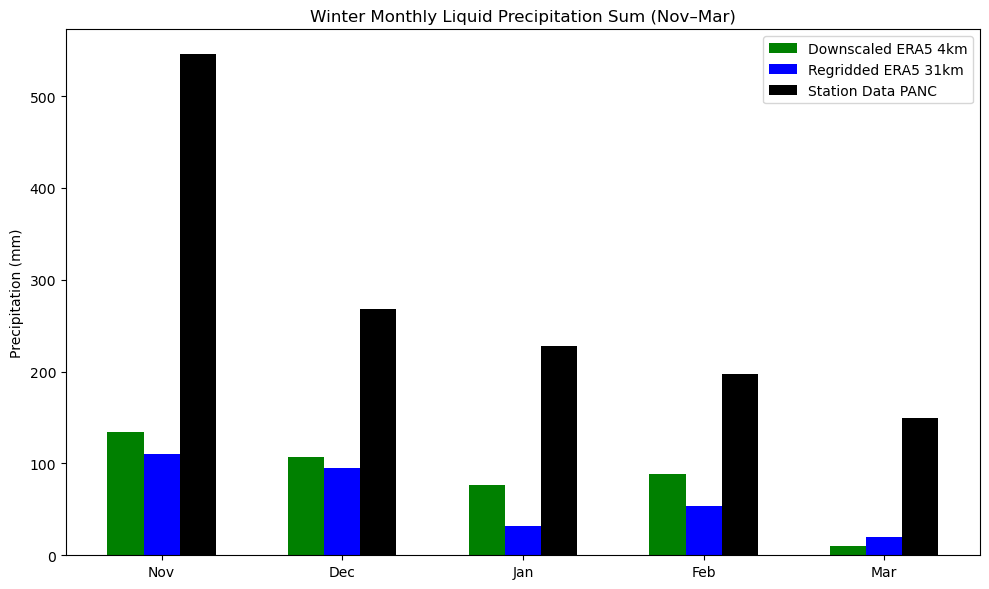

In [26]:
winter_months = [11, 12, 1, 2, 3]          # months in winter
month_labels = ['Nov', 'Dec', 'Jan', 'Feb', 'Mar']
width = 0.2

x = np.arange(len(winter_months))  # [0,1,2,3,4]
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(x - width, monthly_rain_sum_at_site_era5_4km, width, color='green', label='Downscaled ERA5 4km')
ax.bar(x, monthly_rain_sum_at_site_era5_regridded_31km, width, color='blue', label='Regridded ERA5 31km')
ax.bar(x + width, monthly_sum_by_season_ASOS, width, color='black', label='Station Data PANC')

ax.set_xticks(x)
ax.set_xticklabels(month_labels)
ax.set_ylabel('Precipitation (mm)')
ax.set_title('Winter Monthly Liquid Precipitation Sum (Nov–Mar)')
ax.legend()
fig.patch.set_alpha(0.0)
plt.tight_layout()
plt.show()

TypeError: only length-1 arrays can be converted to Python scalars

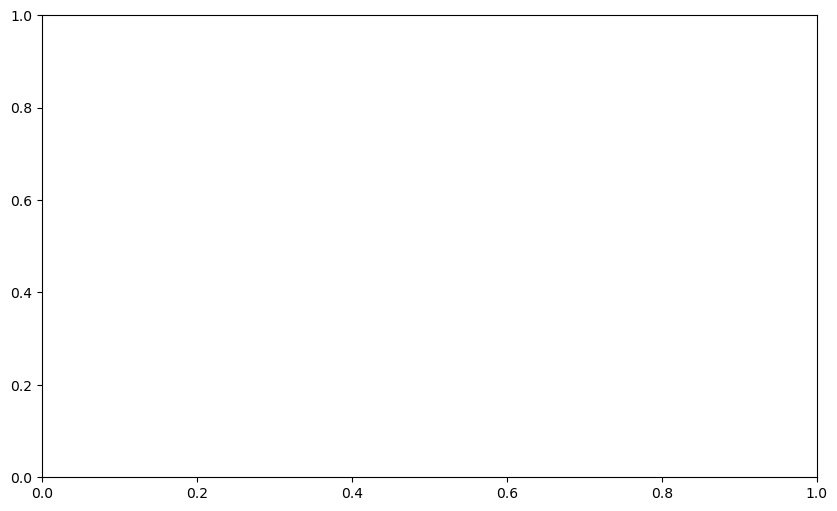

In [38]:


winter_months = [11, 12, 1, 2, 3]          # months in winter
month_labels = ['Nov', 'Dec', 'Jan', 'Feb', 'Mar']
width = 0.2

x = np.arange(len(winter_months))  # [0,1,2,3,4]
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(x - width, monthly_rain_MEAN_at_site_era5_4km, width, color='green', label='Downscaled ERA5 4km')
ax.bar(x, monthly_rain_MEAN_at_site_era5_regridded_31km, width, color='blue', label='Regridded ERA5 31km')
ax.bar(x + width, monthly_mean_by_season_ASOS, width, color='black', label='Station Data PANC')

ax.set_xticks(x)
ax.set_xticklabels(month_labels)
ax.set_ylabel('Precipitation (mm)')
ax.set_title('Winter Monthly Liquid Precipitation MEAN (Nov–Mar)')
ax.legend()
fig.patch.set_alpha(0.0)
plt.tight_layout()
plt.show()

/center1/DYNDOWN/phutton5/VSCODE_dump/ipykernel_1163425/1400723049.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(


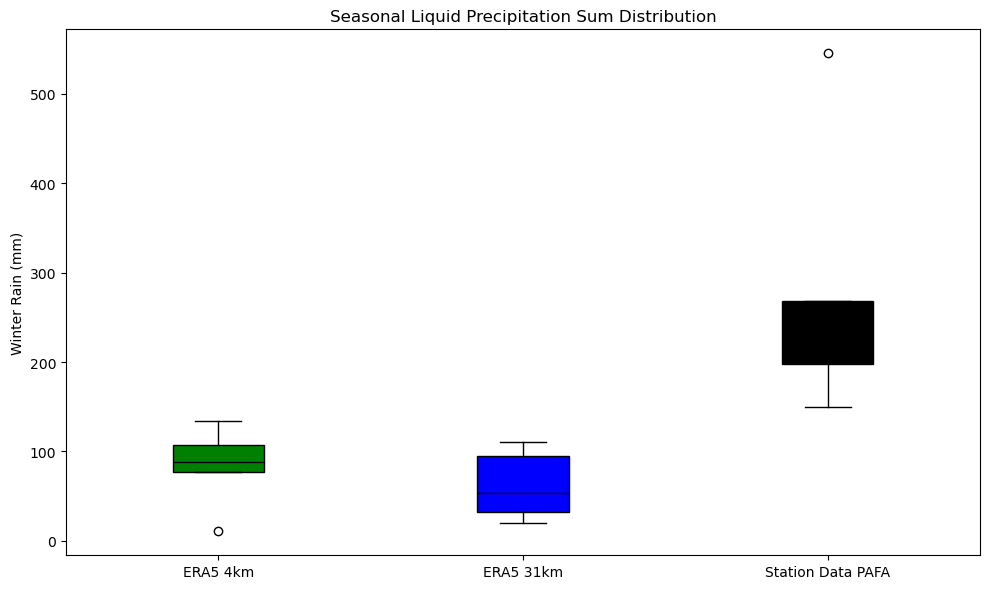

In [27]:
plt.figure(figsize=(10, 6))

data = [
    monthly_rain_sum_at_site_era5_4km.values.flatten(),
    monthly_rain_sum_at_site_era5_regridded_31km.values.flatten(),
    monthly_sum_by_season_ASOS.values.flatten()
]

# Remove NaNs (important!)
data = [d[~np.isnan(d)] for d in data]

labels = ['ERA5 4km', 'ERA5 31km', 'Station Data PAFA']
colors = ['green', 'blue', 'black']

bp = plt.boxplot(
    data,
    labels=labels,
    patch_artist=True,
    medianprops=dict(color='black')
)

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

plt.title('Seasonal Liquid Precipitation Sum Distribution')
plt.ylabel('Winter Rain (mm)')
plt.tight_layout()
plt.show()


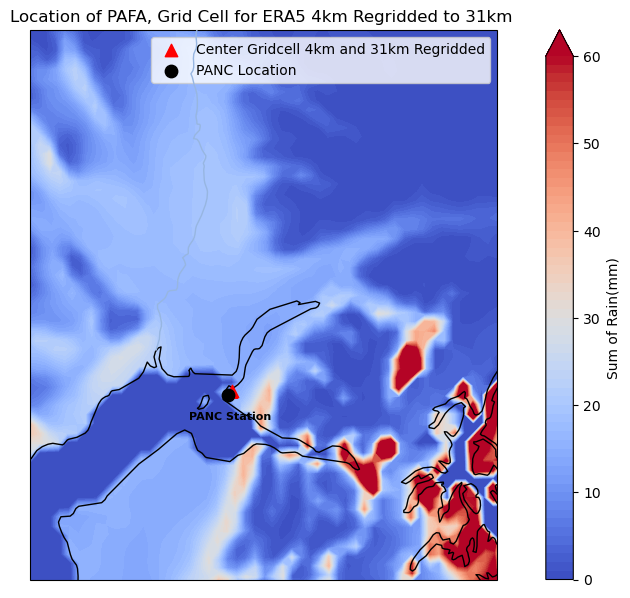

In [42]:
AK_ALBERS_SUBPLOT_KW = {'projection': ccrs.AlbersEqualArea( central_longitude=-154, central_latitude=50, standard_parallels=(55, 65))}
fig, ax = plt.subplots(subplot_kw=AK_ALBERS_SUBPLOT_KW, figsize=(10,6))
cf = ax.contourf(era5_4km['XLONG'], era5_4km['XLAT'], np.mean(era5_4km['ros_tally'],axis=(0,1)) , cmap='coolwarm',levels=np.arange(0,61,1), extend='max',transform=ccrs.PlateCarree())
cbar = fig.colorbar(cf, ax=ax, label='Sum of Rain(mm)', ticks=np.arange(0,70,10))
cbar.ax.set_position([0.77, 0.1, 0.02, 0.8])

#FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=2, transform=ccrs.PlateCarree())
#ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*', color='k', zorder=10, s=80,label='Fairbanks', transform=ccrs.PlateCarree())
#ax.text(Fairbanks_lon, Fairbanks_lat + 0.1, 'Fairbanks',
#        transform=ccrs.PlateCarree(), ha='center', va='bottom',
#        fontsize=8, zorder=10, fontweight='bold', color='black')

ax.scatter(cell.XLONG.values, cell.XLAT.values,marker='^',s=80,color='red',zorder=10,label='Center Gridcell 4km and 31km Regridded',transform=ccrs.PlateCarree()  )

ax.scatter(panc_lon, panc_lat, marker='o', color='black', zorder=10, s=80,label='PANC Location', transform=ccrs.PlateCarree())
ax.text(panc_lon, panc_lat - 0.1, 'PANC Station',
        transform=ccrs.PlateCarree(), ha='center', va='bottom',
        fontsize=8, zorder=10, fontweight='bold', color='black')

ax.add_feature(cfeature.BORDERS, zorder=9)
ax.add_feature(cfeature.COASTLINE, zorder=9)
ax.add_feature(cfeature.RIVERS, zorder=9)

ax.set_extent([-151.5, -148, 60.5, 62.5], crs=ccrs.PlateCarree()) 
ax.set_aspect('equal')
ax.set_title("Location of PANC, Grid Cell for ERA5 4km Regridded to 31km ")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

fig.patch.set_alpha(0.0)
plt.legend()
plt.tight_layout()
plt.show() 

All Rain in The months not just when snow is on the ground 
-

In [29]:
allrain_era5_4km_rain_sum_at_site = era5_4km['rain_sum'].isel(south_north=x_idx,west_east=y_idx)
allrain_monthly_rain_sum_at_site_era5_4km=allrain_era5_4km_rain_sum_at_site.sum(dim='season')

allrain_era5_regridded_31km_rain_sum_at_site = regridded_era5['rain_sum'].isel(south_north=x_idx,west_east=y_idx)
allrain_monthly_rain_sum_at_site_era5_regridded_31km=era5_regridded_31km_rain_sum_at_site.sum(dim='season')


In [30]:
monthly_sum_by_season_ASOS

month
11    545.4851
12    268.6170
1     228.2527
2     197.8849
3     149.3271
Name: p01m, dtype: float64

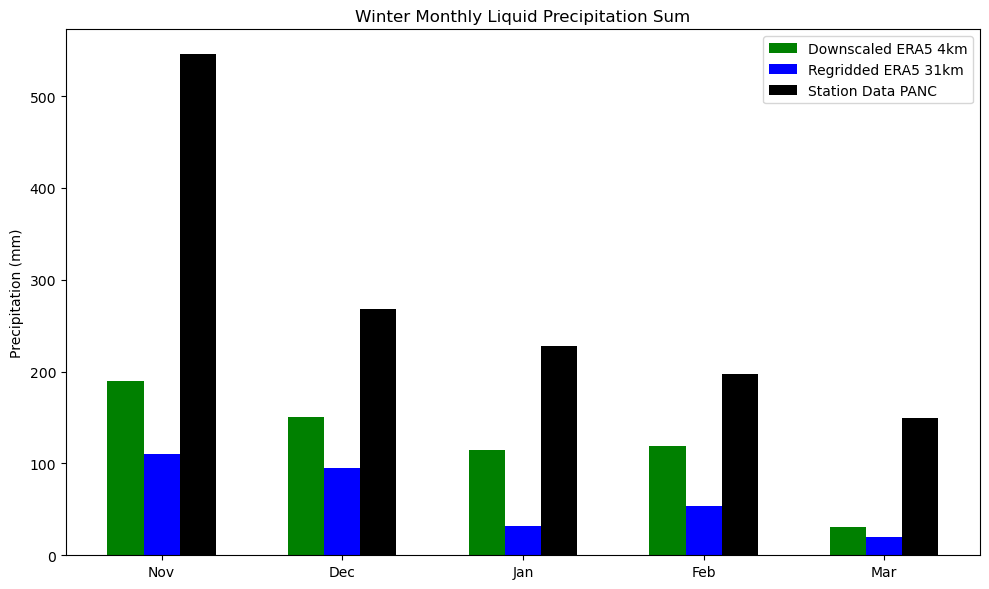

In [33]:
winter_months = [11, 12, 1, 2, 3]          # months in winter
month_labels = ['Nov', 'Dec', 'Jan', 'Feb', 'Mar']
width = 0.2

x = np.arange(len(winter_months))  # [0,1,2,3,4]
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(x - width, allrain_monthly_rain_sum_at_site_era5_4km, width, color='green', label='Downscaled ERA5 4km')
ax.bar(x, allrain_monthly_rain_sum_at_site_era5_regridded_31km, width, color='blue', label='Regridded ERA5 31km')
ax.bar(x + width, monthly_sum_by_season_ASOS, width, color='black', label='Station Data PANC')

ax.set_xticks(x)
ax.set_xticklabels(month_labels)
ax.set_ylabel('Precipitation (mm)')
ax.set_title('Winter Monthly Liquid Precipitation Sum')
ax.legend()
fig.patch.set_alpha(0.0)
plt.tight_layout()
plt.show()